# Building an MPS as a tree and using TDVP for time-evolution
This is a copy of `tebd_mps.ipynb` adapted for TDVP.

A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the easy to implement few-site dynamics.

In [1]:
# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm
from copy import deepcopy

## Setting up and running TDVP

In [2]:
# Define constants
num_sites = 2
virtual_bond_dimension = 7
mJ = 1.5
mg = 0.5

# Define operators
mps = ptn.models.mps_zero(num_sites, virtual_bond_dimension)
ham = ptn.models.mps_heisenberg(num_sites, mJ, 0, 0, mg)

In [3]:
node_shapes = {node_id: mps.nodes[node_id].tensor.shape for node_id in mps.nodes}
print(node_shapes)
print(f"Norm = {np.sqrt(ptn.scalar_product(mps))}")

node_shapes = {node_id: ham.nodes[node_id].tensor.shape for node_id in ham.nodes}
print(node_shapes)

{'site0': (7, 2), 'site1': (7, 2)}
Norm = 1.0
{'site0': (3, 2, 2), 'site1': (3, 2, 2)}


In [4]:
mps.orthogonalize("site1")

In [5]:
time_step_size = 0.001
final_time = 1
# We want to observe the evolution of the Z-operator expectation at each site.
X, Y, Z = ptn.pauli_matrices()
operators = [{node_id: Z} for node_id in mps.nodes]

# We instantiate the TDVP simulation.
tdvp_sim = ptn.TDVP(deepcopy(mps), deepcopy(ham), time_step_size=time_step_size, final_time=final_time, operators=operators)

# After the set up is complete, we merely have to run the simulation.
tdvp_sim.run()

100%|██████████| 1001/1001 [00:04<00:00, 200.58it/s]


## Running the reference matrix vector computation
As a reference we will run a computation on a full state vector. Thus we have to reinitialise the initial state:

In [6]:
zero_state = np.asarray([1,0])

ref_state = zero_state

for site in range(1, num_sites):
    ref_state = np.kron(ref_state, zero_state)
    
# print(f"Initial state {ref_state} is a vector with 2^{num_sites}={len(ref_state)} entries.")

In [7]:
ref_hamiltonian = np.zeros((2**num_sites, 2**num_sites), dtype=complex)

I = np.eye(2)
J = -mJ

ref_state_0 = ref_state
# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, J*X)
        elif site2 == site+1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, I)
    
    ref_hamiltonian += operator
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, mg*Z)
        else:
            operator = np.kron(operator, I)
    
    ref_hamiltonian += operator
    
print(f"The Hamiltonian is a {ref_hamiltonian.shape}-shaped matrix and contains (2^{num_sites})^2={len(ref_state)**2} entries.")

The Hamiltonian is a (4, 4)-shaped matrix and contains (2^2)^2=16 entries.


In [8]:
operators = []

for sites in range(num_sites):
    site_operator = np.asarray([1])
    for sites2 in range(num_sites):
        if sites2 == sites:
            site_operator = np.kron(site_operator, Z)
        else:
            site_operator = np.kron(site_operator, I)
            
    operators.append(site_operator)

In [9]:
num_time_steps = int(np.ceil(final_time / time_step_size))

results = np.zeros((len(operators) + 1, num_time_steps + 1), dtype=complex)

for time_step in range(num_time_steps + 1):
    if time_step != 0:
        ref_state = ptn.fast_exp_action(-1j*time_step_size*ref_hamiltonian, ref_state)
    
    conj_state = np.conjugate(ref_state.T)
    for i, operator in enumerate(operators):
        results[i,time_step] = conj_state @ operator @ ref_state
        
    results[-1,time_step] = time_step * time_step_size

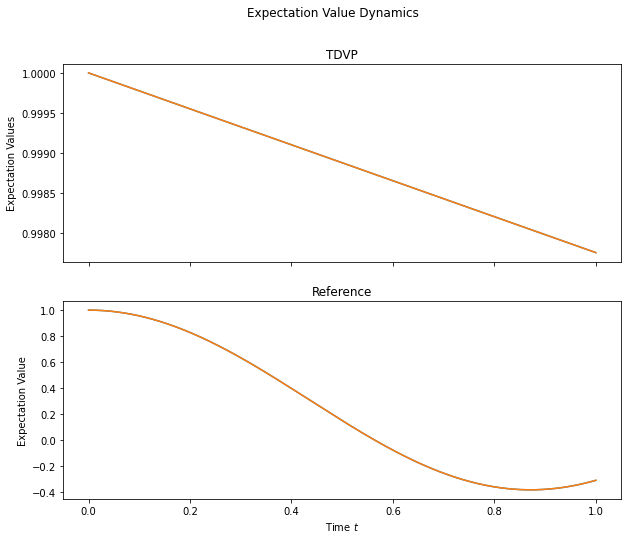

In [10]:
ref_times = [time.real for time in results[-1]]

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,8))

fig.suptitle("Expectation Value Dynamics")

for site in range(num_sites):
    axs[0].plot([time.real for time in tdvp_sim.results[-1]], [exp_val.real for exp_val in tdvp_sim.results[site]])

axs[0].set_ylabel("Expectation Values")
axs[0].set_title("TDVP")

for site in range(num_sites):
    axs[1].plot(ref_times, [exp_val.real for exp_val in results[site]])

axs[1].set_xlabel("Time $t$")
axs[1].set_ylabel("Expectation Value")
axs[1].set_title("Reference")

plt.show()